Imports


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label


## Read in data files names
This is the full set of files from:

https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip

https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

In [2]:
# Read in cars and notcars
#images = glob.glob('fulltest/*.png')
images = glob.glob('jpgfulltest/*.jpg')

cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
print(len(cars), len(notcars))


5966 9943


In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


### Functions below drawn virtually unchanged from the Vehicle Detection lessons.

https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/7355e459-55d0-4f2d-923c-4810c4360267

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    #print("image", img.shape)
    #print("hog", orient, pix_per_cell, cell_per_block, vis, feature_vec)
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


### Extract Features

This function really should be used in common with the somewhat parallel implementation 
in find_cars() below.

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, debug_color=False):
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        file_features = []
        #print("file_features", len(file_features))
        # Read in each one by one
        image = my_img_read(file)
        if debug_color:
            print(np.histogram(image))
        
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        if debug_color:
            print(np.histogram(feature_image))
            
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)

        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        # Append the new feature vector to the features list
        file_features.append(hog_features)

        features.append(np.concatenate(file_features))
        #features = np.hstack((spatial_features, hist_features, hog_features)) 

    # Return list of feature vectors
    return features


### Utitilty function, read images

This function is to put a common read function in place for both jpg and png files.
Outputs a 0-1 valued image, data type is float.


In [5]:
def my_img_read(filename):
    image = mpimg.imread(filename)
    #Setup to return 0-1 range images
    if 'jpg' in filename or 'jpeg' in filename:
        image = image.astype(np.float32)/255
    return image


Test function for loading images, and conversion to int 0-255 values to be used later.  Verifiy with histograms.

jpgfulltest/1.jpg
(array([1053, 4007, 1505, 1150, 1362,  884,  411,  353,  450, 1113]), array([ 0.01960784,  0.11764706,  0.21568628,  0.31372549,  0.41176471,
        0.50980392,  0.60784314,  0.70588235,  0.80392157,  0.90196078,  1.        ]))
<class 'numpy.ndarray'>
float32


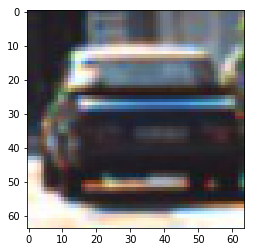

(array([ 872, 4188, 1505, 1150, 1362,  884,  411,  353,  450, 1113]), array([   5.,   30.,   55.,   80.,  105.,  130.,  155.,  180.,  205.,
        230.,  255.]))


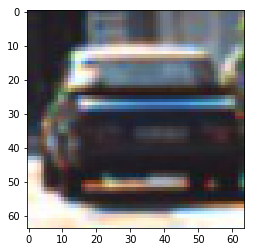

In [8]:
print(cars[0])
image = my_img_read(cars[0])
print(np.histogram(image))

print(type(image))
print(image.dtype)
plt.imshow(image)
plt.show()
image = (image.astype(np.float32)*255).astype(np.uint8)
print(np.histogram(image))

plt.imshow(image)
plt.show()


# All major parameters for SVC training and used by process_image()/find_cars()

In [9]:
### Faster settings
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Train Classifier

In [12]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

/Users/chisolm/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
rand_state=41

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4140


## Search for hyperparameter values, code no longer used.  Results in text windows below


In [14]:
from sklearn.model_selection import GridSearchCV

if False:
    #parameters = {'kernel':('rbf'), 'C':[.0001, .001, .01, 1, 10], 'gamma':[1.0, .1, .01, .001, .0001]}
    parameters = {'C':[.0001, .001, .01, 1, 10], 'gamma':[1.0, .1, .01, .001, .0001]}
    svr = SVC(kernel='rbf')
    clf = GridSearchCV(svr, parameters, verbose=2)
    clf.fit(X_train, y_train)

    print(clf.best_params_)

In [15]:

# Use a linear SVC 
#svc = LinearSVC(C=0.01)
#svc = SVC(kernel='rbf', gamma=1, C=1)

#svc = SVC(kernel='rbf', gamma=.0001, C=10)
svc = LinearSVC(C=0.01)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

12.95 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9972


In [16]:
rand_state


41

# HOG Sub-sampling Window Search

Implementation is take from:
https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/c3e815c7-1794-4854-8842-5d7b96276642

Minimal changes made to accept 0-1 valued images as input.
Also outputs a set of bounding boxes to be used by the heat map code below.

In [51]:
# Define a single function that can extract features using hog sub-sampling and make predictions

# Originally expects and image that is 0-255 range - now expecting 0-1
# Assumes RGB incoming image
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,\
              spatial_size, hist_bins, bbox_return=False):
    
    #print("find input", np.histogram(img))

    bbox_list = []
    draw_img = np.copy(img)
    draw_img = draw_img * 255
    #print("find draw 255", np.histogram(draw_img))

    draw_img = draw_img.astype(np.uint8)
    #print("find draw uint", np.histogram(draw_img))

    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    #print("find tosearch", np.histogram(ctrans_tosearch))
     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #print("hog whole features", img.shape, ch1.shape, hog1.shape, hog2.shape, hog3.shape)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print("how partial features", img.shape, hog_feat1.shape, hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].shape)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print("hist", hist_features.shape, hist_bins)

            # Scale features and make a prediction
            #print("features", spatial_features.shape, hist_features.shape, hog_features.shape)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                if bbox_return == True:
                    bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    if bbox_return == True: 
        return draw_img, bbox_list
        
    return draw_img


Global settings for find_cars()


0 0.5 test 390 530
1 1.0 test 390 530
2 1.5 test 390 575
3 2.0 test 390 625
4 2.5 test 390 675


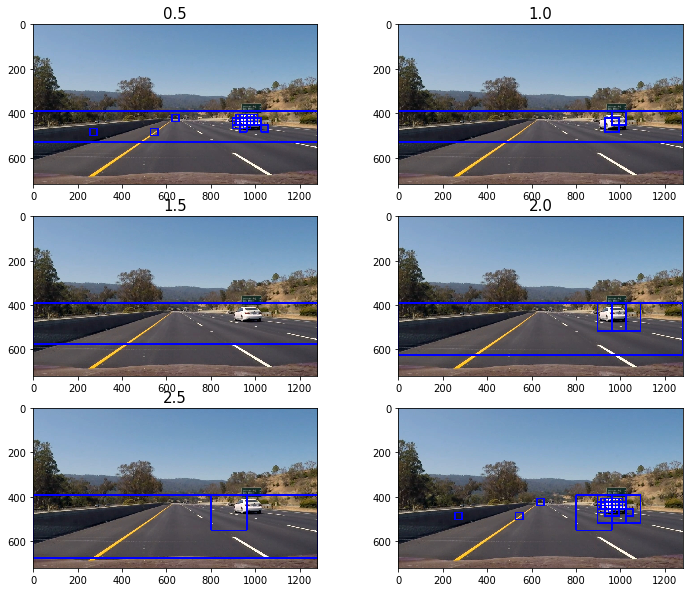

In [52]:
def_start = 390
def_stop = 656
scale = 1.5

#test
#slideparam = [[0.5, def_start, 530], [1.0, def_start, 530], [1.25, def_start, 575], [1.5, def_start, 575], [1.75, def_start, 625], [2.0, def_start, 625], [2.5, def_start, 675], [3.0, def_start, 675]]
slideparam = [[0.5, def_start, 530], [1.0, def_start, 530], [1.5, def_start, 575], [2.0, def_start, 625], [2.5, def_start, 675]]


img = my_img_read('test_images/missing_fit2.jpg')
#img = (img * 255).astype(np.uint8)
    #print("find draw 255", np.histogram(draw_img))

#img = img.astype(np.uint8)

f, axarr = plt.subplots(3, 2, figsize=(12, 10))

master_bb_list = []
for i, param in enumerate(slideparam):
    scale, ystart, ystop = param
    print(i, scale, "test", ystart, ystop)

    bbox_list = []
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,\
                        spatial_size, hist_bins, bbox_return=True)
    cv2.rectangle(out_img,(0, ystart),(1280,ystop),(0,0,255),6) 

    master_bb_list.extend(bbox_list)

    axarr[i//2,i%2].imshow(out_img)
    axarr[i//2,i%2].set_title(str(scale), fontsize=15)

draw_img = (img * 255).astype(np.uint8)

for bbox in master_bb_list:
    cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,255),6) 

axarr[2,1].imshow(draw_img)
#axarr[2,1].axis('off')

plt.show()

In [19]:
img = my_img_read('test_images/test4.jpg')
print(np.histogram(img))

print(ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


(array([149537, 231590, 292264, 538758, 344294, 219124, 335701, 285413,
       343193,  24926]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
390 675 2.5 LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) StandardScaler(copy=True, with_mean=True, with_std=True) 9 16 2 (32, 32) 32


/Users/chisolm/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


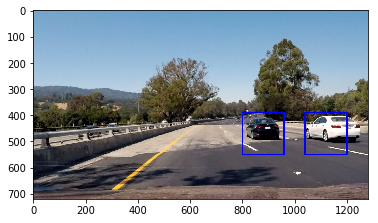

In [20]:
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

/Users/chisolm/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.1 Seconds to test image...
0.1 Seconds to test image...
0.1 Seconds to test image...
0.12 Seconds to test image...
0.11 Seconds to test image...
0.12 Seconds to test image...
0.12 Seconds to test image...
0.14 Seconds to test image...
complete


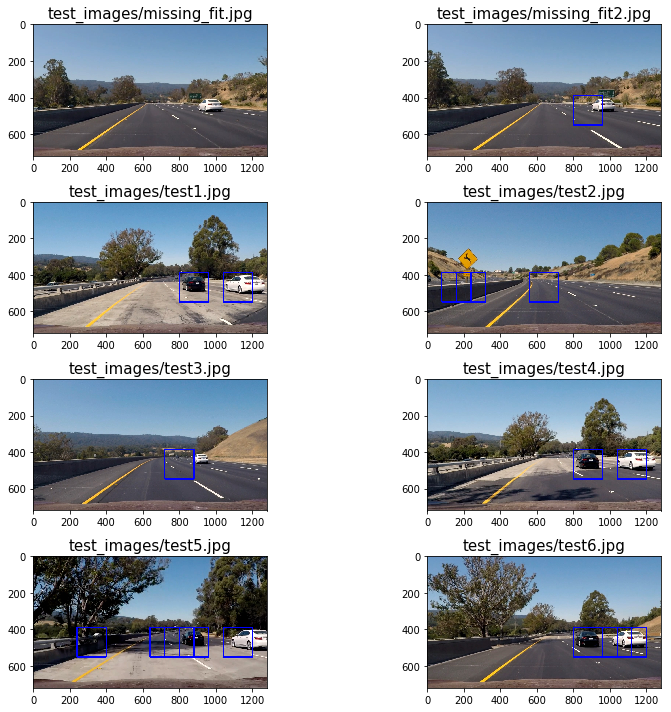

In [21]:
f, axarr = plt.subplots(4, 2, figsize=(12, 10))

for i, filename in enumerate(glob.glob('test_images/*.jpg')):
    img = my_img_read(filename)
    #print(np.histogram(img))

    #img= img.astype(np.float32)/255

    t=time.time()
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to test image...')
    axarr[i//2,i%2].imshow(out_img)
    axarr[i//2,i%2].set_title(filename, fontsize=15)
print('complete')
f.tight_layout()
plt.show()


390 675 2.5 LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) StandardScaler(copy=True, with_mean=True, with_std=True) 9 16 2 (32, 32) 32


/Users/chisolm/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


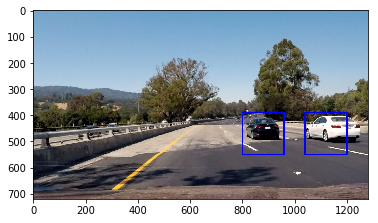

In [22]:
img = my_img_read('test_images/test4.jpg')
#img= img.astype(np.float32)/255

print(ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bbox_return=True)

plt.imshow(out_img)
plt.show()

In [23]:
bbox_list

[((800, 390), (960, 550)), ((1040, 390), (1200, 550))]

## Heat map functions


In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


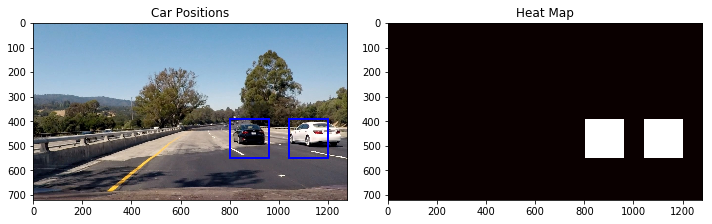

In [25]:

heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
heat = add_heat(heat,bbox_list)
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

# Modify image to draw on it
draw_img = np.copy(img) * 255
draw_img = draw_img.astype(np.uint8)

draw_img = draw_labeled_bboxes(draw_img, labels)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

Simple class to track process control variables and heat map data from frame to frame.

In [33]:
class ProcessData():
    def __init__(self, debug=False, movie=False):
        self.debug = debug
        self.movie = movie
        self.heat_list = []
    def add_heatmap(self, heat):
        self.heat_list.append(heat)
        if len(self.heat_list) > 8: self.heat_list[:1]=[]
    def current_heatmap(self):
        return sum(self.heat_list)
        


## Process_image() loop

Performs initial image setup.

Calls find_cars which implements the HOG sub-sampling code.

Adds the heatmap information.

If setup for debug, will generate a multiview window with heatmap and find_cars output showing
all bounding boxes found on each frame.


In [38]:
def process_image(image):
    debug=process_data.debug
    
    if process_data.movie == True:
        image= image.astype(np.float32)/255

    draw_img = np.copy(image)
    draw_img = draw_img * 255
    draw_img = draw_img.astype(np.uint8)

    def_start = 400
    def_stop = 656

    #slideparam = [[1.0, def_start, 530], [1.5, def_start, 575], [2.0, def_start, 625], [2.5, def_start, 675]]

    master_bb_list = []
    for i, param in enumerate(slideparam):
        scale, ystart, ystop = param

        bbox_list = []
        find_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,\
                                       cell_per_block, spatial_size, hist_bins, bbox_return=True)
        master_bb_list.extend(bbox_list)
    
    zero = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,master_bb_list)
    process_data.add_heatmap(heat)

    totheat = process_data.current_heatmap()
    rawheat = totheat.copy()

    # Apply threshold to help remove false positives
    th_heat = apply_threshold(totheat,20)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(th_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)

    if debug:
        scale_heat = 200 / heatmap.max()
        heatmap = (heatmap * scale_heat) + 50
        heatmap_img = np.dstack((heatmap, zero, zero))
        scale_heat2 = 200 / rawheat.max()
        rawheat = (rawheat * scale_heat2) + 50
        heatmap_img2 = np.dstack((rawheat, zero, zero))

        diag_image = np.zeros((720,1280,3), dtype=np.uint8)
        diag_image[0:360,0:640,:] = cv2.resize(draw_img,(640,360))
        diag_image[0:360,640:1280,:] = cv2.resize(heatmap_img,(640,360))
        diag_image[360:,640:1280,:] = cv2.resize(heatmap_img2,(640,360))
        if type(find_img) != type(None):
            for bbox in master_bb_list:
                cv2.rectangle(find_img,bbox[0],bbox[1],(0,0,255),6) 
            #diag_image[360:,640:1280,:] = cv2.resize(find_img,(640,360))
            diag_image[360:,0:640,:] = cv2.resize(find_img,(640,360))
            
        return diag_image

    return draw_img

float32


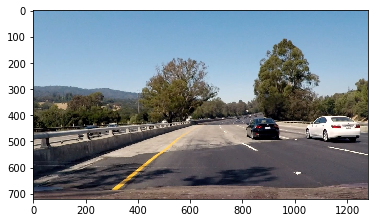

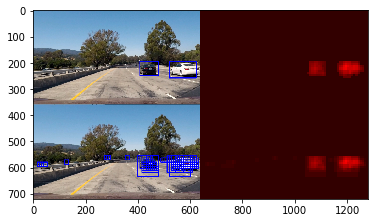

In [34]:
process_data = ProcessData(debug=True)
image = my_img_read('test_images/test4.jpg')
#print(np.histogram(image))
print(image.dtype)
plt.imshow(image)
plt.show()

draw_img = process_image(image)
draw_img = process_image(image)
draw_img = process_image(image)
draw_img = process_image(image)
image = my_img_read('test_images/test1.jpg')
draw_img = process_image(image)
draw_img = process_image(image)
draw_img = process_image(image)
draw_img = process_image(image)

plt.imshow(draw_img)
plt.show()

## Same test with PNG image.

PNG and JPG were the bane of my existance.


(array([149411, 231434, 292163, 537915, 345829, 218760, 337835, 284370,
       342153,  24930]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
<class 'numpy.ndarray'>
float32


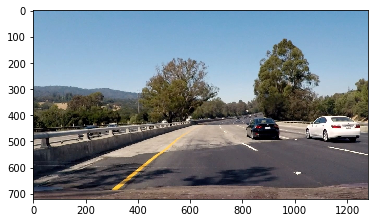

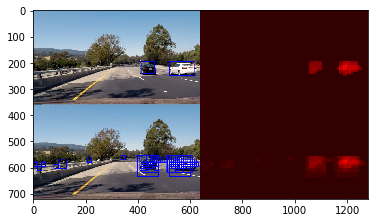

In [35]:
process_data = ProcessData(debug=True)
image = my_img_read('test_images/test4.png')
print(np.histogram(image))

print(type(image))
print(image.dtype)
plt.imshow(image)
plt.show()

draw_img = process_image(image)
draw_img = process_image(image)
draw_img = process_image(image)
draw_img = process_image(image)
draw_img = process_image(image)
plt.imshow(draw_img)
plt.show()

Minimal profile data to see where my time went.


(array([149537, 231590, 292264, 538758, 344294, 219124, 335701, 285413,
       343193,  24926]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))


/Users/chisolm/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


         198762 function calls in 2.842 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.083    0.017    2.644    0.529 <ipython-input-17-d1f3ae601918>:5(find_cars)
        1    0.002    0.002    0.002    0.002 <ipython-input-24-8f5418b0790e>:1(add_heat)
        1    0.003    0.003    0.003    0.003 <ipython-input-24-8f5418b0790e>:11(apply_threshold)
        1    0.002    0.002    0.017    0.017 <ipython-input-24-8f5418b0790e>:17(draw_labeled_bboxes)
        1    0.000    0.000    0.000    0.000 <ipython-input-26-8ec190bafa5c>:6(add_heatmap)
        1    0.000    0.000    0.015    0.015 <ipython-input-26-8ec190bafa5c>:9(current_heatmap)
        1    0.048    0.048    2.828    2.828 <ipython-input-27-ad5539337467>:1(process_image)
        5    0.000    0.000    0.012    0.002 <ipython-input-3-e5e7de2c3a89>:1(convert_color)
       15    0.013    0.001    1.387    0.092 <ipython-input-4-c1208cb35e6d>:2(get_hog_fe

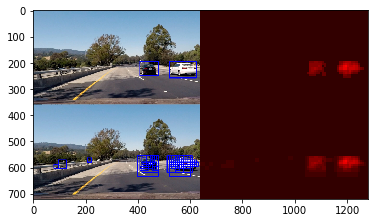

In [30]:
import cProfile

img = my_img_read('test_images/test4.jpg')
#img= img.astype(np.float32)/255

print(np.histogram(img))

#draw_img = process_image(img)
cProfile.run('draw_img = process_image(img)')

plt.imshow(draw_img)
plt.show()

## Video Generation!

What we were all waiting for.


In [39]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_data = ProcessData(debug=True, movie=True)

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(14,20)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [50:31<00:02,  2.26s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 45min 54s, sys: 4min 54s, total: 50min 48s
Wall time: 50min 32s


## Let's see it!

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))